<a href="https://colab.research.google.com/github/dTenebrae/gb-cv/blob/main/cv_lesson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Напишите на Python реализацию как минимум одного алгоритма на выбор: 
- любая на выбор цветовая обработка 
- перевод в другое цветовое пространство 
- фильтрация 

Изображение выберите самостоятельно.

In [ ]:
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

# Функции

### Преобразование RGB в HSV

* Пусть (r, g, b) будут красной, зеленой и синей координатами цвета, а их значения - действительными числами от 0 до 1
* Пусть max будет равно наибольшему из r, g, b
* Пусть min будет равно наименьшему из r, g, b

Тогда,

$
\begin{equation}
  h = \begin{cases}
    0^{\circ} , & \text{if max=min} \\
    60^{\circ} \times \frac{g-b}{max-min} + 0^{\circ}, & \text{if max=r and } g \ge b  \\
    60^{\circ} \times \frac{g-b}{max-min} + 360^{\circ}, & \text{if max=r and } g < b  \\
    60^{\circ} \times \frac{b-r}{max-min} + 120^{\circ}, & \text{if max=g } \\
    60^{\circ} \times \frac{r-g}{max-min} + 240^{\circ}, & \text{if max=b } \\
  \end{cases}
\end{equation} 
$
  
$
\begin{equation}
  s = \begin{cases}
    0 , & \text{if max=0} \\
    \frac{max-min}{max}, & \text{otherwise}  \\
  \end{cases}
\end{equation} 
$

$ v = max $

In [ ]:
def rgb_2_hsv(rgb_pxl) -> np.array:
    """
    Переводит из цветового пространства rgb в hsv

    HSV использует оттенок H, насыщенность S и яркость V для описания изменения цвета.

    Диапазон значений H составляет от 0 ° до 360 °, и он рассчитывается против часовой стрелки
    от красного. Красный - 0 °, зеленый - 120 °, синий. цвет 240 °.

    Чем выше насыщенность S, тем глубже и ярче цвет. Компонент белого света спектрального
    цвета равен 0, а насыщенность самая высокая. Обычно значение находится в
    диапазоне от 0% до 100%. Чем больше значение, тем насыщеннее цвет.

    V представляет яркость цвета.
    Для цвета источника света значение яркости связано с яркостью светящегося тела;
    для цвета объекта это значение связано с коэффициентом пропускания или отражения объекта.
    Обычно значение находится в диапазоне от 0% (черный) до 100% (белый).
    """

    ####################### inner functions ######################################

    def get_h(r, g, b, rgb_max, rgb_min) -> float:
        """
        Возвращает H составляющую
        """
        return {
            (rgb_max == rgb_min): 0,
            (rgb_max == r) and (g >= b): 60 * (g - b) / (rgb_max - rgb_min + 1e-7),
            (rgb_max == r) and (g < b): 60 * (g - b) / (rgb_max - rgb_min + 1e-7) + 360,
            (rgb_max == g): 60 * (b - r) / (rgb_max - rgb_min + 1e-7) + 120,
            (rgb_max == b): 60 * (r - g) / (rgb_max - rgb_min + 1e-7) + 240,
        }[True]

    def get_s(rgb_max, rgb_min) -> float:
        """
        Возвращает S составляющую
        """
        return {
            rgb_max == 0: 0,
            rgb_max != 0: 1 - rgb_min / rgb_max
        }[True]

    ##############################################################################

    # проверяем, та ли длина нам пришла на вход
    assert len(rgb_pxl) == 3, "Wrong dim"

    # отрезаем значения за пределами диапазона [0, 255]
    # приводим к float
    # и для удобства расчетов, распихиваем составляющие на отдельные переменные
    r, g, b = np.clip(rgb_pxl, 0, 255) / 255

    # находим max, min
    rgb_max = max(r, g, b)
    rgb_min = min(r, g, b)

    # переводим в hsv пространство
    h = get_h(r, g, b, rgb_max, rgb_min)
    s = get_s(rgb_max, rgb_min) * 100
    v = rgb_max * 100

    return np.round([h, s, v], 1)

### Обратное преобразование HSV в RGB 
Условие

$ H \in [0^{\circ}, 360^{\circ}] $  
$ S \in [0, 1] $  
$ V \in [0, 1] $  

$ C = V \times S $  
$ X = C \times (1 - |(H/60^{\circ})mod 2 - 1|) $  
$ m = V - C $  


Тогда,

$
\begin{equation}
  (R', G', B') = \begin{cases}
    (C, X, 0) , & 0^{\circ} \leq H \leq 60^{\circ} \\
    (X, C, 0) , & 60^{\circ} \leq H \leq 120^{\circ} \\
    (0, C, X) , & 120^{\circ} \leq H \leq 180^{\circ} \\
    (0, X, C) , & 180^{\circ} \leq H \leq 240^{\circ} \\
    (X, 0, C) , & 240^{\circ} \leq H \leq 300^{\circ} \\
    (C, 0, X) , & 300^{\circ} \leq H \leq 360^{\circ} \\
  \end{cases}
\end{equation} 
$

$ (R, G, B) = ((R' + m) \times 255, (G' + m) \times 255, (B' + m) \times 255)$

In [ ]:
def hsv_2_rgb(hsv_pxl: np.array) -> np.array:
    """
    Обратное преобразование из HSV в RGB
    На входе ожидаем Numpy массив из 3-х элементов h, s, v соответственно
    Значения h должны лежать в пределах [0, 360]
    Значения s,v - либо [0, 1], либо [0, 100]. Если второй вариант - приводим к [0, 1]

    На выходе numpy array из 3-х unsigned интов RGB
    """
    assert len(hsv_pxl) == 3, "Wrong dim"

    h, s, v = hsv_pxl

    if not (0.0 <= h <= 360.0):
        raise ValueError("H should be in range from 0 to 360")

    if not (0.0 <= v <= 100.0):
        raise ValueError("S and V should be in range from 0 to 1 or from 0 to 100")

    if s > 1:
        s /= 100
    if v > 1:
        v /= 100

    if s == 0:
        v *= 255
        return np.array([v, v, v]).astype(np.uint8)

    h /= 60
    i = int(h)
    c = h - i

    x, y, z = int(255 * (v * (1. - s))), \
              int(255 * (v * (1. - s * c))), \
              int(255 * (v * (1. - s * (1. - c))))
    v *= 255
    if i == 0: return np.array([v, z, x]).astype(np.uint8)
    if i == 1: return np.array([y, v, x]).astype(np.uint8)
    if i == 2: return np.array([x, v, z]).astype(np.uint8)
    if i == 3: return np.array([x, y, v]).astype(np.uint8)
    if i == 4: return np.array([z, x, v]).astype(np.uint8)
    if i == 5: return np.array([v, x, y]).astype(np.uint8)

In [ ]:
def lesson_window(img, fl):
    """
    Модифицированная функция с урока, которая применяет окно фильтрации на все каналы изображения.
    Очень медленная
    """        
    def channel_filter(channel):
        out_img = np.zeros(
            (channel.shape[0] - fl.shape[0] + 1,
             channel.shape[1] - fl.shape[1] + 1), 
             dtype=np.float32)

        for i in range(out_img.shape[0]):
            for j in range(out_img.shape[1]):
                x = channel[i:i+fl.shape[0], j:j + fl.shape[1]]

                out_img[i,j] = np.sum(fl * x)
        return out_img
    
    result = []
    for channel in range(img.shape[2]):
        result.append(channel_filter(img[:, :, channel]))
    return np.dstack(result).astype(np.uint8)

In [ ]:
def ml_gauss2D(size=5, sigma=3):
    """
    Матлабовский вариант фильтра по Гауссовскому закону распределения
    """
    x, y = np.mgrid[-size // 2 + 1: size // 2 + 1, -size // 2 + 1: size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2)/(2.0 * sigma ** 2)))
    return g / g.sum()

In [ ]:
def rgb_2_gray(rgb):
    """
    Преобразование в grayscale по заветам matplotlib'a
    """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
def slow_transform(img, func):
    """
    Медленная и печальная функция попиксельного изменения изображения
    двумя питоновскими циклами.
    """
    prev_shape = img.shape
    result = []
    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            result.append(func(img[i, j, :]))
    return np.array(result).reshape(prev_shape)

In [ ]:
def short_transform(img, func):
    """
    По скорости тоже самое, что выше, но несколько короче запись
    """
    reshaped_img = img.reshape(1, -1, 3).squeeze()
    result = np.array(list(map(func, reshaped_img))).reshape(img.shape)
    return result

In [ ]:
def img_resize(img, res=320):
    """
    Фунция умешьшения разрешения картинки. Работает только для результирующего разрешения,
    на которое изначальное делится нацело. Каналы изображения предполагаются в конце.
    """
    input_size = img.shape[0]
    output_size = res
    bin_size = input_size // output_size
    small_image = img.reshape((output_size, bin_size,
                               output_size, bin_size, 3)).max(3).max(1)
    return small_image

___

## Обработка изображения

In [ ]:
large_image = imageio.imread('1920px-Lenna.png')


In [ ]:
large_image.shape

(1920, 1920, 3)

### Resize

In [ ]:
small_image = img_resize(large_image)

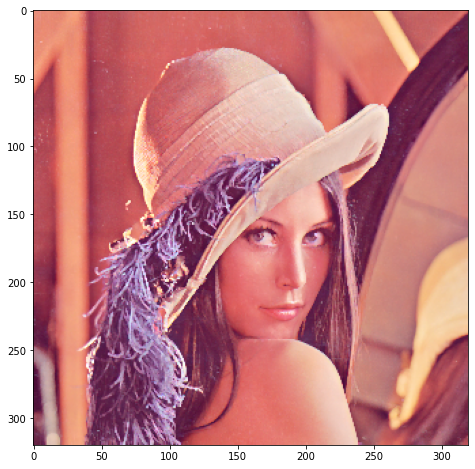

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(small_image);

## Цветовое пространство

#### Grayscale

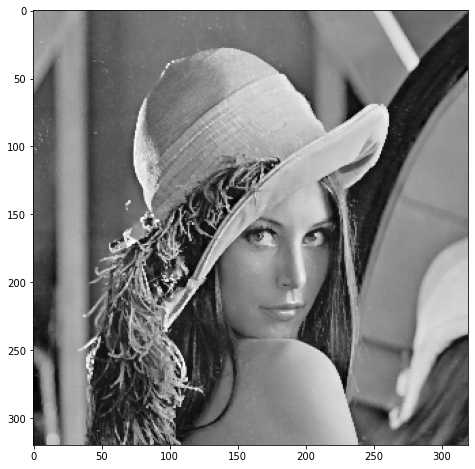

In [ ]:
img = rgb_2_gray(small_image)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap="gray");

#### HSV

In [ ]:
# переведем в HSV
img_hsv = slow_transform(small_image, rgb_2_hsv)

In [ ]:
# изменим, например, яркость
img_hsv[:, :, 2] /= 10

In [ ]:
# обратная трансформация в RGB
img_rgb = slow_transform(img_hsv, hsv_2_rgb)

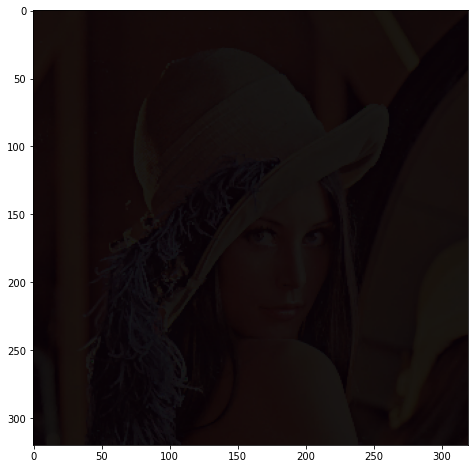

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb);

## Фильтрация

In [ ]:
# четкий фильтр
f1 = np.ones((3, 3)) * -1
f1[1, 1] = 9
f1

array([[-1., -1., -1.],
       [-1.,  9., -1.],
       [-1., -1., -1.]])

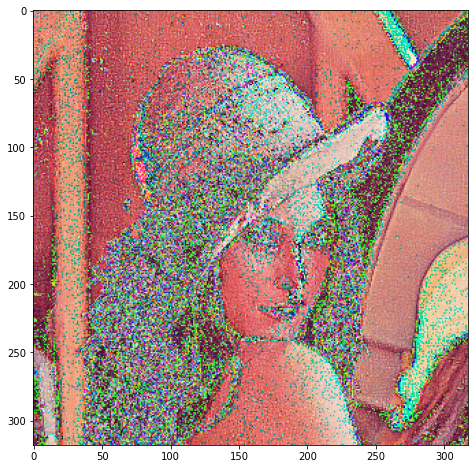

In [ ]:
img = lesson_window(small_image, f1)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()

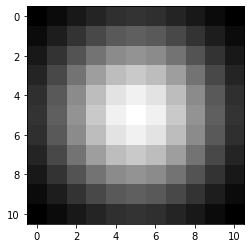

In [ ]:
f2 = ml_gauss2D(size=11, sigma=3)
plt.imshow(f2, cmap='gray');

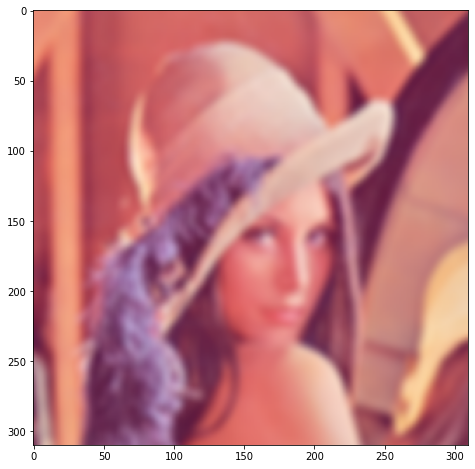

In [ ]:
img = lesson_window(small_image, f2)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()

___

In [ ]:
%%timeit
slow_transform(small_image, rgb_2_hsv)

5.63 s ± 90.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
short_transform(small_image, rgb_2_hsv)

5.32 s ± 89.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
